## Задание
Домашнее задание к занятию «Улучшение качества обучения нейросети»

Цель задания: научиться использовать в коде различные методы Transfer Learning.

Задание:
На примере датасета персонажей мультфильма Симпсонов:

    Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.
    Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.
    Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались на занятии.
    Оформите вывод по результатам проведённых экспериментов.

Формат сдачи работы
Прикрепите ссылку на готовое решение в личном кабинете. Работу можно отправлять в виде ссылки на python-ноутбук из GitHub, Google Colaboratory или аналогичных платформ. Не забудьте открыть доступ на просмотр и комментирование.

Критерии оценивания
По итогу выполнения задания вы получите - зачёт/незачёт.

Задание считается выполненным, если:

    LR Schedulers применяются корректно, проведено 2 эксперимента
    при изменении аугментацией Accuracy сильно (> 10 процентов) уменьшилась
    корректно проведено обучение и дообучение любой сети (VGG, EfficientNet или MobileNet), получены сравнимые результаты или лучше по сравнению с практикой на занятии
    итоговый вывод содержит подробный корректный анализ проведённых экспериментов

Документация по schedulers
    https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

### 1. Подготовка
#### 1.1. Импорт библиотек

In [1]:
# импорт библиотек

import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline
import datetime
from torchvision.models import resnet18

#### 1.2. Настройка устройства для расчётов

In [2]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu" # строка для запуска на домашнем компьютере
# device = "cuda" # строка для запуска в Colab
print(device)

cpu


#### 1.4. Загрузка данных

In [3]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
# не разобрался как подняться на папку вверх в ссылке, поэтому использовал полную ссылку
data_dir = "/home/vk/OneDrive/Образование/Слава/Нетология/16. DLL-30 Deep Learning/Материалы/simpsons/simpsons_dataset" 
# data_dir = "simpsons/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths, 
    test_size=0.3,
    stratify=data_image_labels
)
print(f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}")

Изображений в train: 14653
Изображений в val: 6280


In [4]:
# создаю списки для хранения результатов
model_type_list, augmentation_type_list, scheduler_type_list, epoch_list, l_rate, train_accuracy, train_losses, test_accuracy, test_losses = [], [], [], [], [], [], [], [], []

#### 1.3. Вспомогательные функции

In [5]:
# функция для визуализации
def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

In [6]:
# функция для вывода графиков лосса и метрики во время обучения 
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()
    plt.show()

In [7]:
# функция обучения
def train(
    model_type,
    augmentation_type,
    learning_rate,    
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=5,
    scheduler_type=None,
    schedulers=None,
    s_names=None
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list)) # словарь для хранения статистики обучения

    for epoch in range(num_epochs): # итерируемся по эпохам
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        n = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for i, (X_batch, y_batch) in enumerate(train_batch_gen):
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch) # предсказания
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy()) # так написано, чтобы сохранить только значения, а не градиенты
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

            n = y_batch.shape[0]

            # вывод информации о текущем статусе обучения
            if i % 10 == 0:
                print(f"Step {i}. time since epoch: {time.time() -  start_time:.3f}.")

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # пополняю списки. понимаю, что можно сделать эффективнее, но так проще для понимания
        train_accuracy.append(train_acc)
        train_losses.append(train_loss)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for i, (X_batch, y_batch) in enumerate(val_batch_gen):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        # пополняю списки. понимаю, что можно сделать эффективнее, но так проще для понимания
        test_accuracy.append(val_acc)
        test_losses.append(val_loss)        

        model_type_list.append(model_type)
        augmentation_type_list.append(augmentation_type)
        scheduler_type_list.append(scheduler_type)
        epoch_list.append(epoch+1)

        clear_output() # стираем предыдущий график

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
        # подключаю scheduler и обновляю learning_rate
        if schedulers is not None:
            for scheduler, name in zip(schedulers, s_names): 
                if name == 'ReduceLROnPlateau':
                    scheduler.step(val_loss)
                else:
                    scheduler.step()
                    l_rate.append(scheduler.get_last_lr()[0])
        else:
            l_rate.append(learning_rate)

    return model, history

#### 1.4. Настройка

In [8]:
batch_size = 64 # размер батча
epochs = 20 # количество эпох
input_size = 224 # определяем размер изображения
learning_rate = 0.01

#### 1.5. Аугментации

##### Беру базовый набор аугментаций, как на лекции в качестве отправной точки.

In [9]:
# набор аугментаций не идеален
train_transform = transforms.Compose([ # применяем аугментации
    transforms.Resize(input_size), # размер
    transforms.CenterCrop(input_size), # центр кроп
    transforms.ColorJitter(0.9, 0.9, 0.9), # изменение цветов (небольшое)
    transforms.RandomAffine(5), # что-то вроде растяжения и поворота одновременно
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder( # принимает изображения в указанном формате
    data_dir, # ссылка на директорию с изображениями
    transform=train_transform, # применяем трансформации
    is_valid_file=lambda x: x in train_files_path # оперделяет, нужно ли использовать картинку (если путь в тестовых - да, в остальных случаях нет)
)

val_dataset = torchvision.datasets.ImageFolder( # аналогично предыдущему блоку
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [10]:
# проверяю, что получилось в результате разделения
print("Количество изображений в train: ", len(train_dataset.imgs))
print("Количество изображений в val: ", len(val_dataset.imgs))
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество изображений в train:  14653
Количество изображений в val:  6280
Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


#### 1.6. Dataloader

In [11]:
# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

#### 1.8. Визуализация тестового и валидационного датасаетов

##### Т.к. аугментации, мягко говоря, не очень, то и картинки не очень.

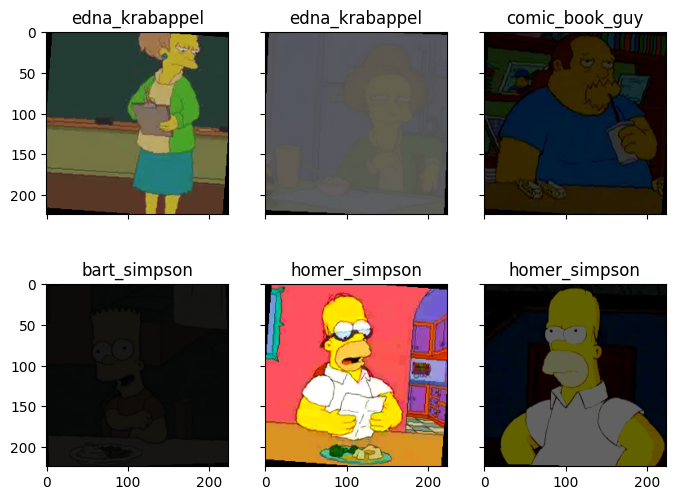

In [12]:
show_images(train_dataset)

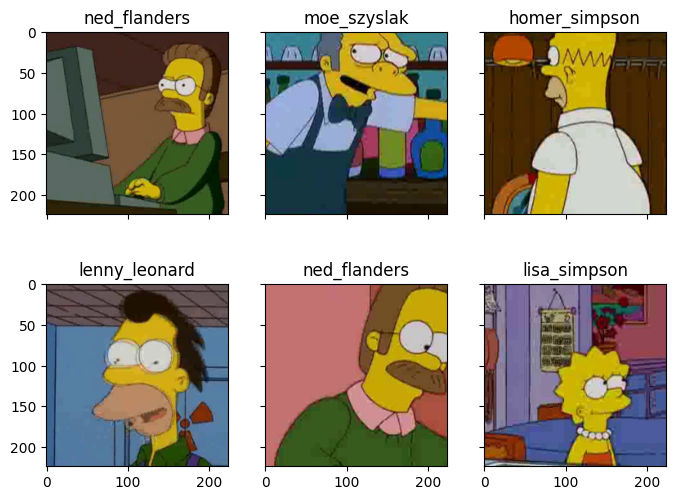

In [13]:
show_images(val_dataset)

### 2. Обучение моделей

#### 2.1. Выбор модели

##### В качестве модели решил использовать MobileNet, т.к. заявлено, что она более быстрая, что важно, т.к. у меня нет gpu. Экспериментировал с ResNet18, MobileNet_v2, MobileNet_v3_large, MobileNet_v3_small, в результате решил остановиться на ней, как на самой быстрообучаемой, при этом увеличил количесно эпох до 20. На 20 эпохах MobileNet_v3_small показывает приблизительно такие же параметры, как и ResNet18 на 10 эпохах, но время обучения значительно меньше.

##### Определившись с моделью, запускаю 3 варианта обучения - "с нуля", "feature extractor" и "fine tuning" и смотрю, что получилось.

In [14]:
from torchvision.models import mobilenet_v3_small

In [15]:
# смотрю как устроена модель
model = mobilenet_v3_small(weights=None)
model.classifier

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)

##### Меняю аугментации: взял полный набор разных аугментаций, из которых выбрал оптимальные для обучения.

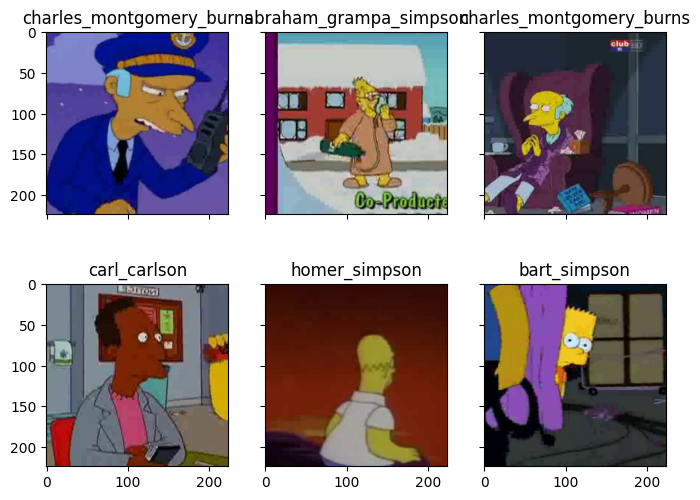

In [16]:
# оптимальный набор аугментаций, те, которые считаю неоптимальными, закомментированы
train_transform = transforms.Compose([ # применяем аугментации
    transforms.Resize(input_size), # привожу к размеру входного изображения
    transforms.CenterCrop(input_size), # центр кроп
    transforms.RandomHorizontalFlip(p=0.5), # зеркально поворачиваю изображение по горизонтали
    # transforms.RandomVerticalFlip(p=0.5), # зеркально поворачиваю изображение по вертикали
    # transforms.ColorJitter(0.9, 0.9, 0.9), # изменение цветов
    # transforms.RandomAffine(5), # что-то вроде растяжения и поворота одновременно
    # transforms.ElasticTransform(alpha=50.0, sigma=5.0), # эластичная трансформация / рябь по воде (значения оставил по умолчанию)
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder( # принимает изображения в указанном формате
    data_dir, # ссылка на директорию с изображениями
    transform=train_transform, # применяем трансформации
    is_valid_file=lambda x: x in train_files_path # оперделяет, нужно ли использовать картинку (если путь в тестовых - да, в остальных случаях нет)
)

val_dataset = torchvision.datasets.ImageFolder( # аналогично предыдущему блоку
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)


# загружаю изображения в dataloader
# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

show_images(train_dataset) # сразу посмотреть, что получилось

##### Картинки выглядят явно получше, чем в примере выше.

In [17]:
start_time = datetime.datetime.now()

##### 2.1.1. Обучение "с нуля"

Epoch 20 of 20 took 220.951s
  training loss (in-iteration): 	0.797247
  validation loss (in-iteration): 	1.011006
  training accuracy: 			78.53 %
  validation accuracy: 			73.88 %


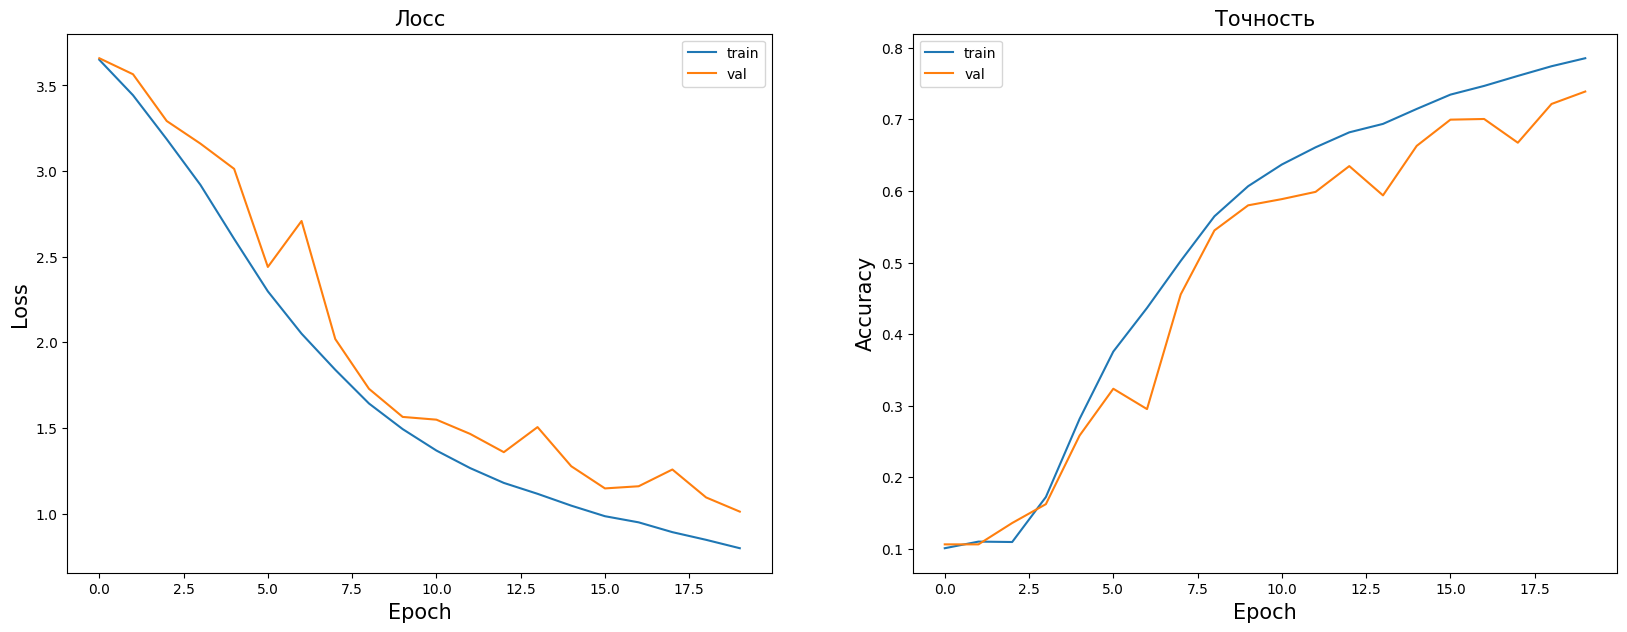

In [18]:
# дублирую настройки в блок с моделью для удобства
model_type = 'From_zero'
augmentation_type = 'Optimal'
learning_rate = 0.01
# epochs = 20

model.classifier[3] = nn.Linear(1024, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

clf_model, history = train(
    model_type,
    augmentation_type,
    learning_rate,    
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=epochs,
    scheduler_type=None,
    schedulers=None,
    s_names=None
)

##### 2.1.2. Обучение "Feature extractor"

Epoch 20 of 20 took 88.230s
  training loss (in-iteration): 	1.033268
  validation loss (in-iteration): 	1.088506
  training accuracy: 			74.25 %
  validation accuracy: 			72.95 %


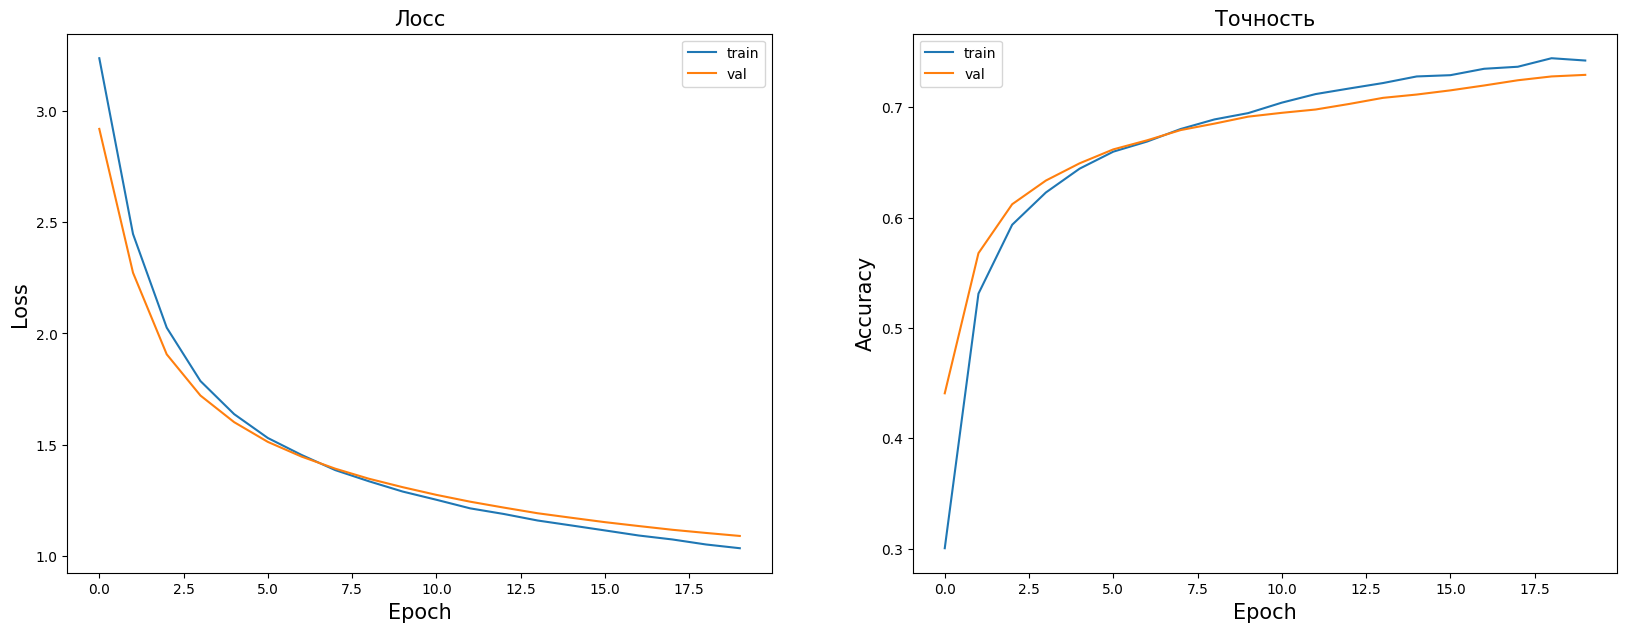

In [19]:
# дублирую настройки в блок с моделью для удобства
model_type = 'Feature_extractor'
augmentation_type = 'Optimal'
learning_rate = 0.01
# epochs = 20

# возьмём предобученную сеть
fe_model = mobilenet_v3_small(weights='DEFAULT')

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
    
fe_model.classifier[3] = nn.Linear(1024, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=learning_rate)

clf_model, history = train(
    model_type,
    augmentation_type,
    learning_rate,    
    fe_model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=epochs,
    scheduler_type=None,
    schedulers=None,
    s_names=None
)

##### 2.1.3. Обучение "Fine tuning"

Epoch 20 of 20 took 176.018s
  training loss (in-iteration): 	0.043711
  validation loss (in-iteration): 	0.246706
  training accuracy: 			99.18 %
  validation accuracy: 			94.05 %


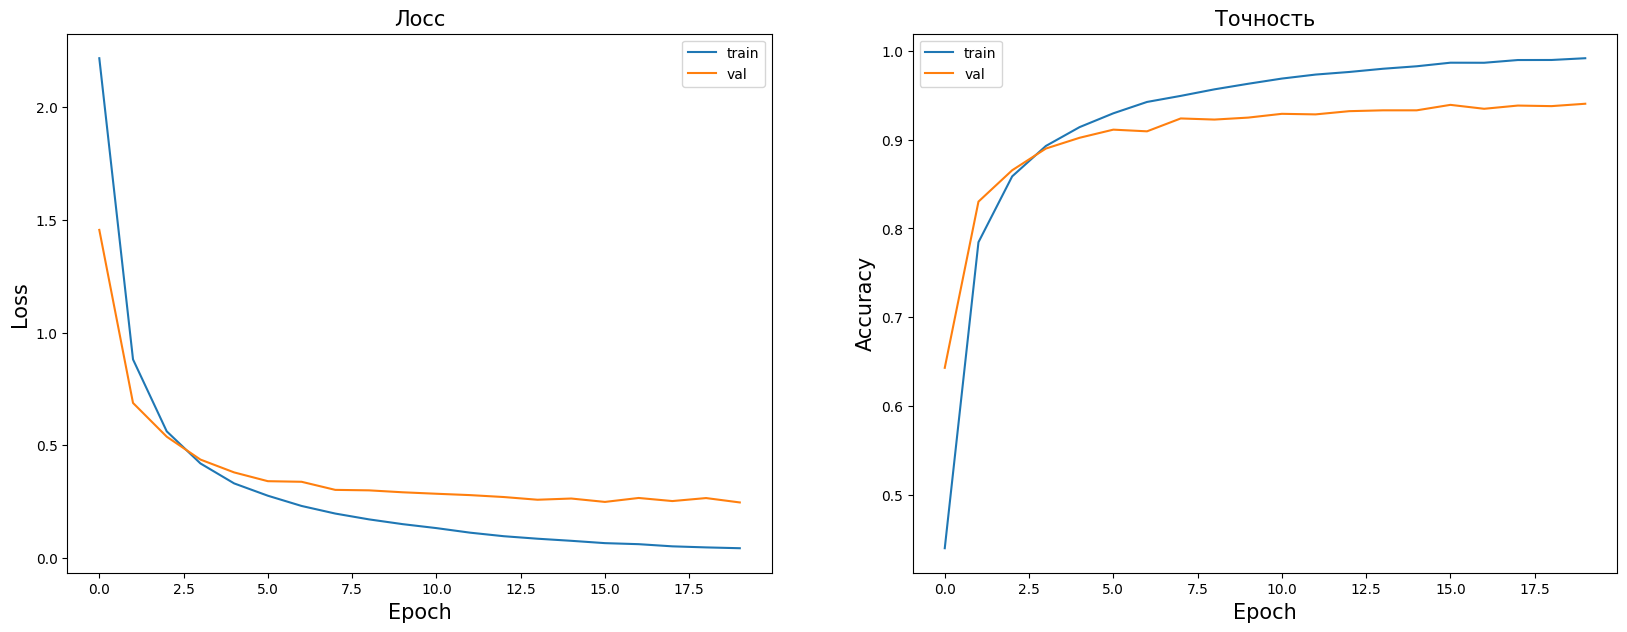

In [20]:
# дублирую настройки в блок с моделью для удобства
model_type = 'Fine_tuning'
augmentation_type = 'Optimal'
learning_rate = 0.01
# epochs = 20

fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('mobilenet_v3_small', mobilenet_v3_small(weights='DEFAULT'))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    model_type,
    augmentation_type,
    learning_rate,    
    fine_tuning_model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=epochs,
    scheduler_type=None,
    schedulers=None,
    s_names=None
)

In [21]:
end_time = datetime.datetime.now()
print(f'start_time:\t{start_time}')
print(f'end_time:\t{end_time}')

start_time:	2024-03-04 23:41:33.652017
end_time:	2024-03-05 02:16:28.457303


In [22]:
# model = resnet18(weights=None) # не используем предобученную модель, обучаем с нуля
# model.fc = nn.Linear(512, 42)
# model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# clf_model, history = train(
#     model, criterion, optimizer, 
#     train_batch_gen, val_batch_gen, 
#     num_epochs=epochs
# )

##### Привожу статистику для обучения к удобному для анализа виду. См. датафрейм ниже.

In [23]:
model_type_list, augmentation_type_list, scheduler_type_list, epoch_list, l_rate, train_accuracy, train_losses, test_accuracy, test_losses 

(['From_zero',
  'From_zero',
  'From_zero',
  'From_zero',
  'From_zero',
  'From_zero',
  'From_zero',
  'From_zero',
  'From_zero',
  'From_zero',
  'From_zero',
  'From_zero',
  'From_zero',
  'From_zero',
  'From_zero',
  'From_zero',
  'From_zero',
  'From_zero',
  'From_zero',
  'From_zero',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Feature_extractor',
  'Fine_tuning',
  'Fine_tuning',
  'Fine_tuning',
  'Fine_tuning',
  'Fine_tuning',
  'Fine_tuning',
  'Fine_tuning',
  'Fine_tuning',
  'Fine_tuning',
  'Fine_tuning',
  'Fine_tuning',
  'Fine_tuning',
  'Fine_tuning',
  'Fine_tuning',
  

In [24]:
df_results= pd.DataFrame(columns = ['model_type', 'augmentation_type', 'scheduler_type', 'train_accuracy', 'test_accuracy', 'train_losses', 'test_accuracy', 'test_losses'])
df_results

,model_type,augmentation_type,scheduler_type,train_accuracy,test_accuracy,train_losses,test_accuracy,test_losses


In [59]:
df_results= pd.DataFrame(columns = [
  'model_type', 
  'augmentation_type', 
  'scheduler_type', 
  'epoch_list', 
  'learning_rat', 
  'train_accuracy', 
  'train_losses', 
  'test_accuracy', 
  'test_losses'])
for i in range(len(model_type_list)):
  df_results.loc[len(df_results.index)] = [
  model_type_list[i], 
  augmentation_type_list[i], 
  scheduler_type_list[i], 
  epoch_list[i], 
  l_rate[i], 
  train_accuracy[i], 
  train_losses[i], 
  test_accuracy[i], 
  test_losses[i]]
df_results.to_csv('Results.csv')
df_results[df_results['scheduler_type'].isnull()] # строка добавлена, т.к. перезепускал ячейку после окончания обучения, чтобы отразить только те данные, которые
                                                  # изначально были на этом этапе

,model_type,augmentation_type,scheduler_type,epoch_list,learning_rat,train_accuracy,train_losses,test_accuracy,test_losses
0,From_zero,Optimal,None,1,0.01,0.100993,3.650262,0.106376,3.659269
1,From_zero,Optimal,None,2,0.01,0.110231,3.443086,0.106376,3.565636
2,From_zero,Optimal,None,3,0.01,0.109661,3.186289,0.136206,3.292557
3,From_zero,Optimal,None,4,0.01,0.172516,2.919460,0.162563,3.160451
4,From_zero,Optimal,None,5,0.01,0.281600,2.603927,0.258365,3.013004
5,From_zero,Optimal,None,6,0.01,0.375616,2.297644,0.323706,2.440112
6,From_zero,Optimal,None,7,0.01,0.436570,2.050379,0.295297,2.708586
7,From_zero,Optimal,None,8,0.01,0.502226,1.839451,0.455492,2.019118
8,From_zero,Optimal,None,9,0.01,0.564538,1.642529,0.544823,1.728317
9,From_zero,Optimal,None,10,0.01,0.606572,1.492870,0.579861,1.564155


##### На протяжении всего обучения каждая из моделей показывала улучшение результата. Т.к. меня интересуют итоговые результаты, то посмотрю только на данные последней эпохи.
##### 3-е место у Feature extractor, видимо, обучения только последнего слоя классификатора недостаточно для хороших результатов. 
##### На 2-м месте идёт модель, обученная "с нуля". Предполагаю, что если увеличить количество эпох, то можно добиться более хороших результатов.
##### Лидирует со значительным отрывом модель "Fine tuning", в которой совмещены предобученные веса и слои обученные на данных этого датасета.

In [63]:
df_results[(df_results['scheduler_type'].isnull()) & (df_results['epoch_list']==20)]

,model_type,augmentation_type,scheduler_type,epoch_list,learning_rat,train_accuracy,train_losses,test_accuracy,test_losses
19,From_zero,Optimal,None,20,0.01,0.785294,0.797247,0.738794,1.011006
39,Feature_extractor,Optimal,None,20,0.01,0.742482,1.033268,0.729482,1.088506
59,Fine_tuning,Optimal,None,20,0.01,0.991809,0.043711,0.940499,0.246706


#### 2.2. Применяю schedulers к лучшей по качеству модели "Fine tuning"

##### Как и было установлено на лекции, и подтверждено в ходе экспериментов выше, наилучшее качество даёт fine tuning предобученной модели. Попробую поставить 2 эксперимента с shedulers. Цель - проверить, возможно ли достичь такого же или лучшего результата за меньшее количество эпох. Экспериментировать буду с ConstantLR и StepLR, применяя их к модели fine tuning, которую принимаю за эталон.

##### 2.2.1. ConstantLR

Epoch 20 of 20 took 176.685s
  training loss (in-iteration): 	0.053116
  validation loss (in-iteration): 	0.246674
  training accuracy: 			98.82 %
  validation accuracy: 			93.80 %


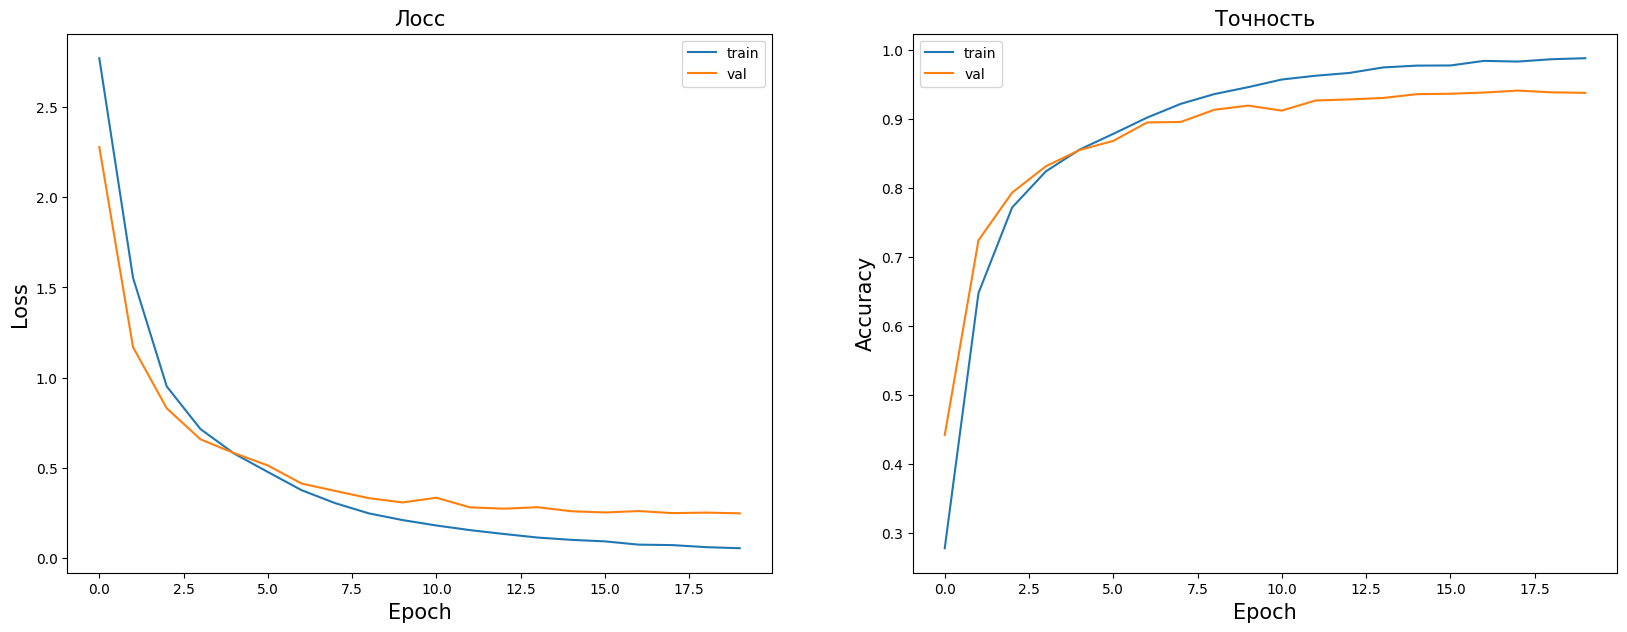

In [27]:
# дублирую настройки в блок с моделью для удобства
model_type = 'Fine_tuning'
augmentation_type = 'Optimal'
learning_rate = 0.01
# epochs = 20

fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('mobilenet_v3_small', mobilenet_v3_small(weights='DEFAULT'))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

# настраиваю scheduler
scheduler_type = 'ConstantLR'
schedulers = []
scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer=optimizer, factor=0.5, total_iters=5)
schedulers.append(scheduler)
s_names = 'ConstantLR'

clf_model, history = train(
    model_type,
    augmentation_type,
    learning_rate,    
    fine_tuning_model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=epochs,
    scheduler_type=scheduler_type,
    schedulers=schedulers,
    s_names=s_names
)

##### 2.2.2. StepLR

Epoch 20 of 20 took 177.048s
  training loss (in-iteration): 	0.227396
  validation loss (in-iteration): 	0.326655
  training accuracy: 			94.39 %
  validation accuracy: 			91.41 %


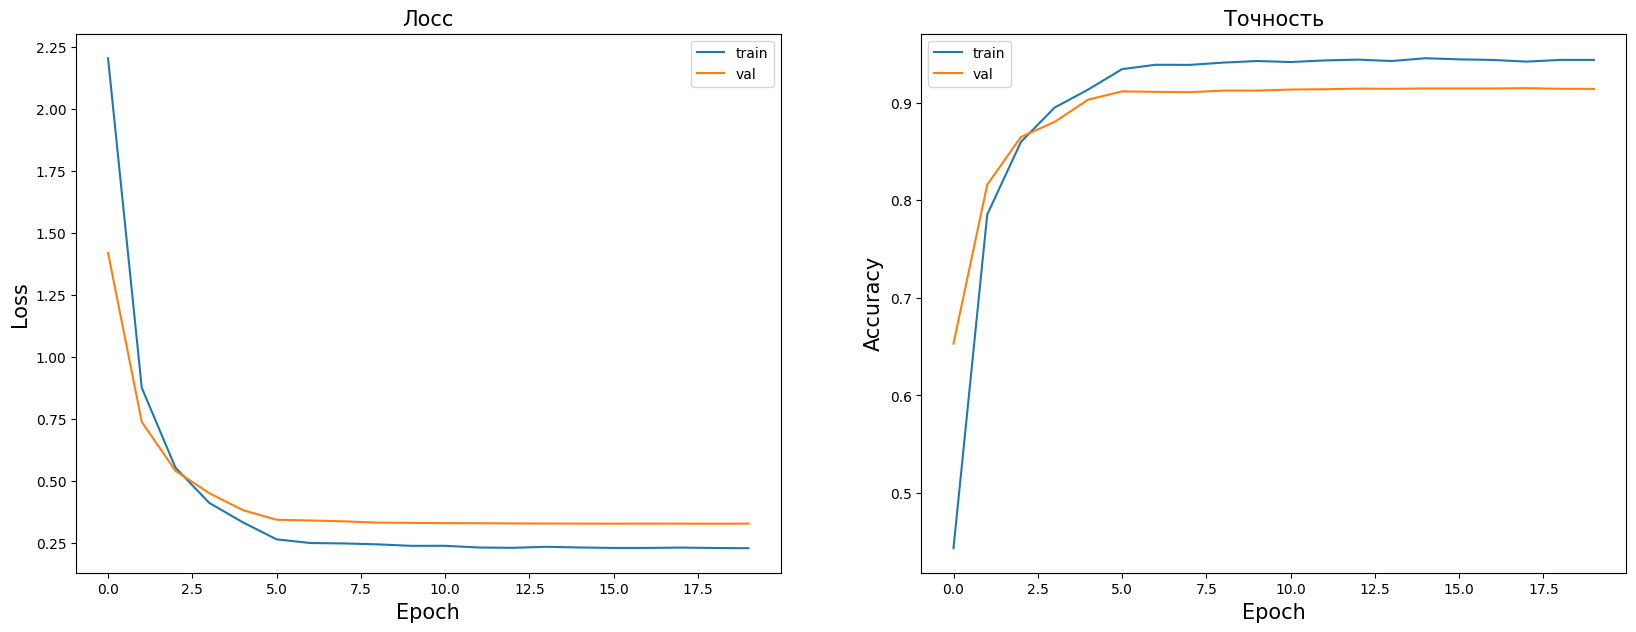

In [28]:
# дублирую настройки в блок с моделью для удобства
model_type = 'Fine_tuning'
augmentation_type = 'Optimal'
learning_rate = 0.01
# epochs = 20

fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('mobilenet_v3_small', mobilenet_v3_small(weights='DEFAULT'))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

# настраиваю scheduler
scheduler_type = 'StepLR'
schedulers = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
schedulers.append(scheduler)
s_names = 'StepLR'

clf_model, history = train(
    model_type,
    augmentation_type,
    learning_rate,    
    fine_tuning_model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=epochs,
    scheduler_type=scheduler_type,
    schedulers=schedulers,
    s_names=s_names
)

In [29]:
# model_type_list, augmentation_type_list, scheduler_type_list, epoch_list, l_rate, train_accuracy, train_losses, test_accuracy, test_losses

In [30]:
df_results= pd.DataFrame(columns = [
  'model_type', 
  'augmentation_type', 
  'scheduler_type', 
  'epoch_list', 
  'learning_rat', 
  'test_accuracy', 
  'train_losses', 
  'test_accuracy', 
  'test_losses'])
for i in range(len(model_type_list)):
  df_results.loc[len(df_results.index)] = [
  model_type_list[i], 
  augmentation_type_list[i], 
  scheduler_type_list[i], 
  epoch_list[i], 
  l_rate[i], 
  train_accuracy[i], 
  train_losses[i], 
  test_accuracy[i], 
  test_losses[i]]
df_results.to_csv('Results.csv')
df_results

,model_type,augmentation_type,scheduler_type,epoch_list,learning_rat,test_accuracy,train_losses,test_accuracy,test_losses
0,From_zero,Optimal,None,1,0.010000,0.100993,3.650262,0.106376,3.659269
1,From_zero,Optimal,None,2,0.010000,0.110231,3.443086,0.106376,3.565636
2,From_zero,Optimal,None,3,0.010000,0.109661,3.186289,0.136206,3.292557
3,From_zero,Optimal,None,4,0.010000,0.172516,2.919460,0.162563,3.160451
4,From_zero,Optimal,None,5,0.010000,0.281600,2.603927,0.258365,3.013004
...,...,...,...,...,...,...,...,...,...
95,Fine_tuning,Optimal,StepLR,16,0.000010,0.944439,0.228501,0.914615,0.326557
96,Fine_tuning,Optimal,StepLR,17,0.000010,0.943842,0.228570,0.914615,0.326731
97,Fine_tuning,Optimal,StepLR,18,0.000010,0.942130,0.229959,0.914931,0.326607
98,Fine_tuning,Optimal,StepLR,19,0.000010,0.943907,0.228324,0.914299,0.326220


##### Полный список результатов слишком большой, отфильтрую те, где использовались schedulers.

In [69]:
# перезапускал ячейку после окончания обучения, поэтому пришлось наложить дополнительные фильтры.
df_results[(df_results['scheduler_type'].notnull()) & (df_results['augmentation_type']=='Optimal')]

,model_type,augmentation_type,scheduler_type,epoch_list,learning_rat,train_accuracy,train_losses,test_accuracy,test_losses
60,Fine_tuning,Optimal,ConstantLR,1,0.005000,0.277946,2.771809,0.442077,2.279633
61,Fine_tuning,Optimal,ConstantLR,2,0.005000,0.647722,1.554123,0.724274,1.169235
62,Fine_tuning,Optimal,ConstantLR,3,0.005000,0.771947,0.951078,0.793403,0.829472
63,Fine_tuning,Optimal,ConstantLR,4,0.005000,0.824196,0.714485,0.831597,0.657496
64,Fine_tuning,Optimal,ConstantLR,5,0.010000,0.855793,0.578145,0.855114,0.580668
65,Fine_tuning,Optimal,ConstantLR,6,0.010000,0.878596,0.476180,0.868371,0.512528
66,Fine_tuning,Optimal,ConstantLR,7,0.010000,0.902061,0.375077,0.895044,0.411875
67,Fine_tuning,Optimal,ConstantLR,8,0.010000,0.922053,0.303001,0.895833,0.371067
68,Fine_tuning,Optimal,ConstantLR,9,0.010000,0.936255,0.246303,0.913510,0.330756
69,Fine_tuning,Optimal,ConstantLR,10,0.010000,0.946234,0.209147,0.919508,0.307255


##### ConstantLR - был выбран не совсем удачно. На первых 5 эпохах learning rate был снижен, что замедлило обучение (к концу 5 эпохи test accuracy оригинальной модели 90,2%, а при использовании ConstantLR 85.5%). Затем lr вернулся к нормальному уровню, что позволило закончить обучение с результатами, близкими к оригинальной модели (93,8% против 94.0%).
##### StepLR - не самым удачным образом были подобраны параметры, lr значительно снижается каждые 5 эпох, что также тормозит обучение по мере нарастания количества эпох.
##### Предполагаю, что хорошие результаты мог бы показать CyclicLR, при условии обучения на большом количестве эпох.

#### 2.3. Ухудшаю качество лучшей модели путём изменения аугментаций. Поиздеваюсь над Симпсонами, применю разные аугментации, которые навряд ли встретятся на самом деле. Визуализирую тот ужас, который получился.

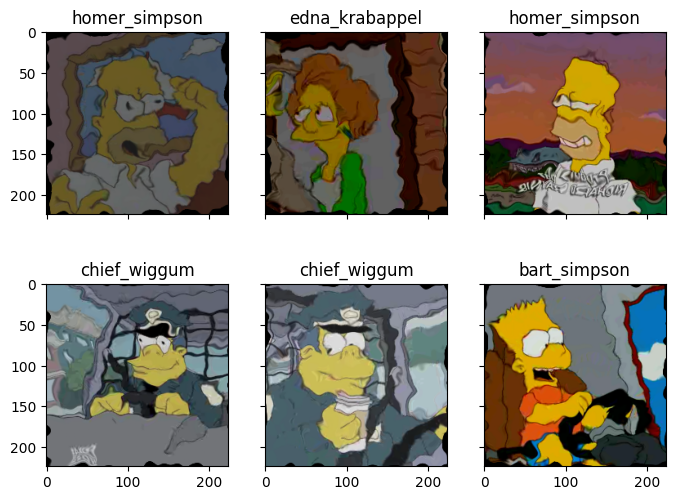

In [31]:
# оптимальный набор аугментаций, те, которые считаю неоптимальными, закомментированы
train_transform = transforms.Compose([ # применяем аугментации
    transforms.Resize(input_size), # привожу к размеру входного изображения
    transforms.CenterCrop(input_size), # центр кроп
    transforms.RandomHorizontalFlip(p=0.5), # зеркально поворачиваю изображение по горизонтали
    # transforms.RandomVerticalFlip(p=0.5), # зеркально поворачиваю изображение по вертикали
    transforms.ColorJitter(0.5, 0.5, 0.5), # изменение цветов
    transforms.RandomAffine(5), # что-то вроде растяжения и поворота одновременно
    transforms.ElasticTransform(alpha=150.0, sigma=5.0), # эластичная трансформация / рябь по воде (значения оставил по умолчанию)
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder( # принимает изображения в указанном формате
    data_dir, # ссылка на директорию с изображениями
    transform=train_transform, # применяем трансформации
    is_valid_file=lambda x: x in train_files_path # оперделяет, нужно ли использовать картинку (если путь в тестовых - да, в остальных случаях нет)
)

val_dataset = torchvision.datasets.ImageFolder( # аналогично предыдущему блоку
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)


# загружаю изображения в dataloader
# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

show_images(train_dataset) # сразу посмотреть, что получилось

##### Применю к получившемуся ужасу последнюю модель, т.е. fine tuning со scheduler StepLR. Возможно, она неоптимальна, однако задача ухудшить качество, а каждая итерация обучения модели на моём компьютере занимает около часа, поэтому с точки зрения выполнение ДЗ использую имеющуюся последнюю модель.

Epoch 20 of 20 took 376.768s
  training loss (in-iteration): 	0.419113
  validation loss (in-iteration): 	0.436484
  training accuracy: 			88.88 %
  validation accuracy: 			88.51 %


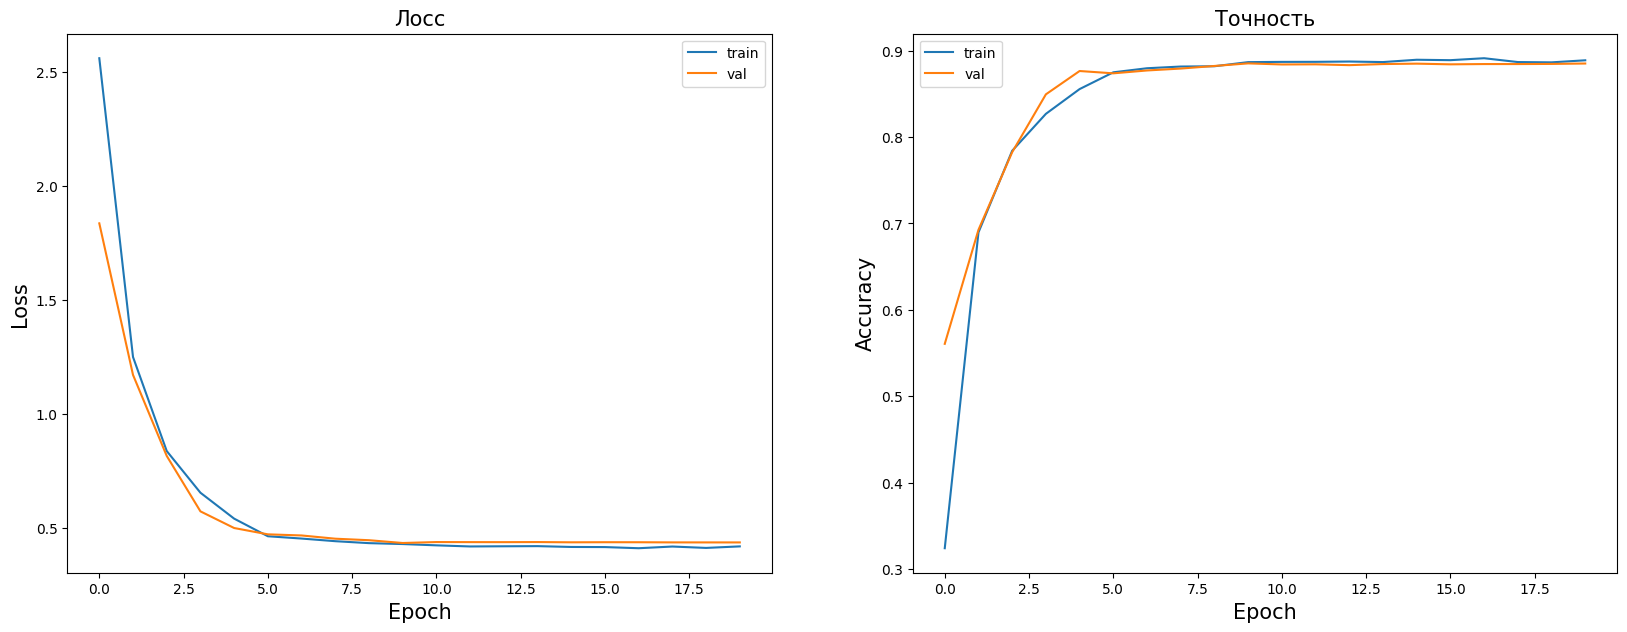

In [32]:
# дублирую настройки в блок с моделью для удобства
model_type = 'Fine_tuning'
augmentation_type = 'Bad'
learning_rate = 0.01
# epochs = 20

fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('mobilenet_v3_small', mobilenet_v3_small(weights='DEFAULT'))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

# настраиваю scheduler
scheduler_type = 'StepLR'
schedulers = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
schedulers.append(scheduler)
s_names = 'StepLR'

clf_model, history = train(
    model_type,
    augmentation_type,
    learning_rate,    
    fine_tuning_model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=epochs,
    scheduler_type=scheduler_type,
    schedulers=schedulers,
    s_names=s_names
)

In [33]:
end_time = datetime.datetime.now()
print(f'start_time:\t{start_time}')
print(f'end_time:\t{end_time}')

start_time:	2024-03-04 23:41:33.652017
end_time:	2024-03-05 06:20:12.548893


In [34]:
df_results= pd.DataFrame(columns = [
  'model_type', 
  'augmentation_type', 
  'scheduler_type', 
  'epoch_list', 
  'learning_rat', 
  'test_accuracy', 
  'train_losses', 
  'test_accuracy', 
  'test_losses'])
for i in range(len(model_type_list)):
  df_results.loc[len(df_results.index)] = [
  model_type_list[i], 
  augmentation_type_list[i], 
  scheduler_type_list[i], 
  epoch_list[i], 
  l_rate[i], 
  train_accuracy[i], 
  train_losses[i], 
  test_accuracy[i], 
  test_losses[i]]
df_results.to_csv('Results.csv')
df_results

,model_type,augmentation_type,scheduler_type,epoch_list,learning_rat,test_accuracy,train_losses,test_accuracy,test_losses
0,From_zero,Optimal,None,1,0.010000,0.100993,3.650262,0.106376,3.659269
1,From_zero,Optimal,None,2,0.010000,0.110231,3.443086,0.106376,3.565636
2,From_zero,Optimal,None,3,0.010000,0.109661,3.186289,0.136206,3.292557
3,From_zero,Optimal,None,4,0.010000,0.172516,2.919460,0.162563,3.160451
4,From_zero,Optimal,None,5,0.010000,0.281600,2.603927,0.258365,3.013004
...,...,...,...,...,...,...,...,...,...
115,Fine_tuning,Bad,StepLR,16,0.000010,0.888964,0.416081,0.884154,0.437422
116,Fine_tuning,Bad,StepLR,17,0.000010,0.891222,0.411075,0.884470,0.437284
117,Fine_tuning,Bad,StepLR,18,0.000010,0.886791,0.418482,0.884470,0.436645
118,Fine_tuning,Bad,StepLR,19,0.000010,0.886439,0.412418,0.884628,0.436553


In [78]:
df_results[(df_results['model_type']=='Fine_tuning') 
        & ((df_results['augmentation_type']=='Optimal') | (df_results['augmentation_type']=='Bad'))
        & (df_results['epoch_list']==20)
        & (df_results['scheduler_type']=='StepLR')
          ]

,model_type,augmentation_type,scheduler_type,epoch_list,learning_rat,train_accuracy,train_losses,test_accuracy,test_losses
99,Fine_tuning,Optimal,StepLR,20,0.000001,0.943904,0.227396,0.914141,0.326655
119,Fine_tuning,Bad,StepLR,20,0.000001,0.888827,0.419113,0.885101,0.436484


##### Как ни странно, сеть справилась не так уж плохо, качество на тесте снизилось на 3%, попробую ещё ухудшить аугментации.

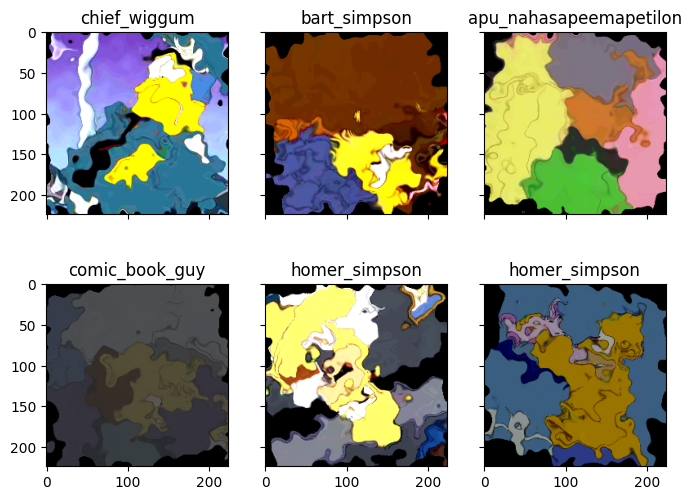

In [37]:
# оптимальный набор аугментаций, те, которые считаю неоптимальными, закомментированы
train_transform = transforms.Compose([ # применяем аугментации
    transforms.Resize(input_size), # привожу к размеру входного изображения
    transforms.CenterCrop(input_size), # центр кроп
    transforms.RandomHorizontalFlip(p=0.5), # зеркально поворачиваю изображение по горизонтали
    transforms.RandomVerticalFlip(p=0.5), # зеркально поворачиваю изображение по вертикали
    transforms.ColorJitter(0.5, 0.5, 0.5), # изменение цветов
    transforms.RandomAffine(20), # что-то вроде растяжения и поворота одновременно
    transforms.ElasticTransform(alpha=350.0, sigma=5.0), # эластичная трансформация / рябь по воде (значения оставил по умолчанию)
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder( # принимает изображения в указанном формате
    data_dir, # ссылка на директорию с изображениями
    transform=train_transform, # применяем трансформации
    is_valid_file=lambda x: x in train_files_path # оперделяет, нужно ли использовать картинку (если путь в тестовых - да, в остальных случаях нет)
)

val_dataset = torchvision.datasets.ImageFolder( # аналогично предыдущему блоку
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)


# загружаю изображения в dataloader
# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

show_images(train_dataset) # сразу посмотреть, что получилось

In [38]:
start_time = datetime.datetime.now()

Epoch 20 of 20 took 410.751s
  training loss (in-iteration): 	0.947857
  validation loss (in-iteration): 	1.078962
  training accuracy: 			74.19 %
  validation accuracy: 			71.18 %


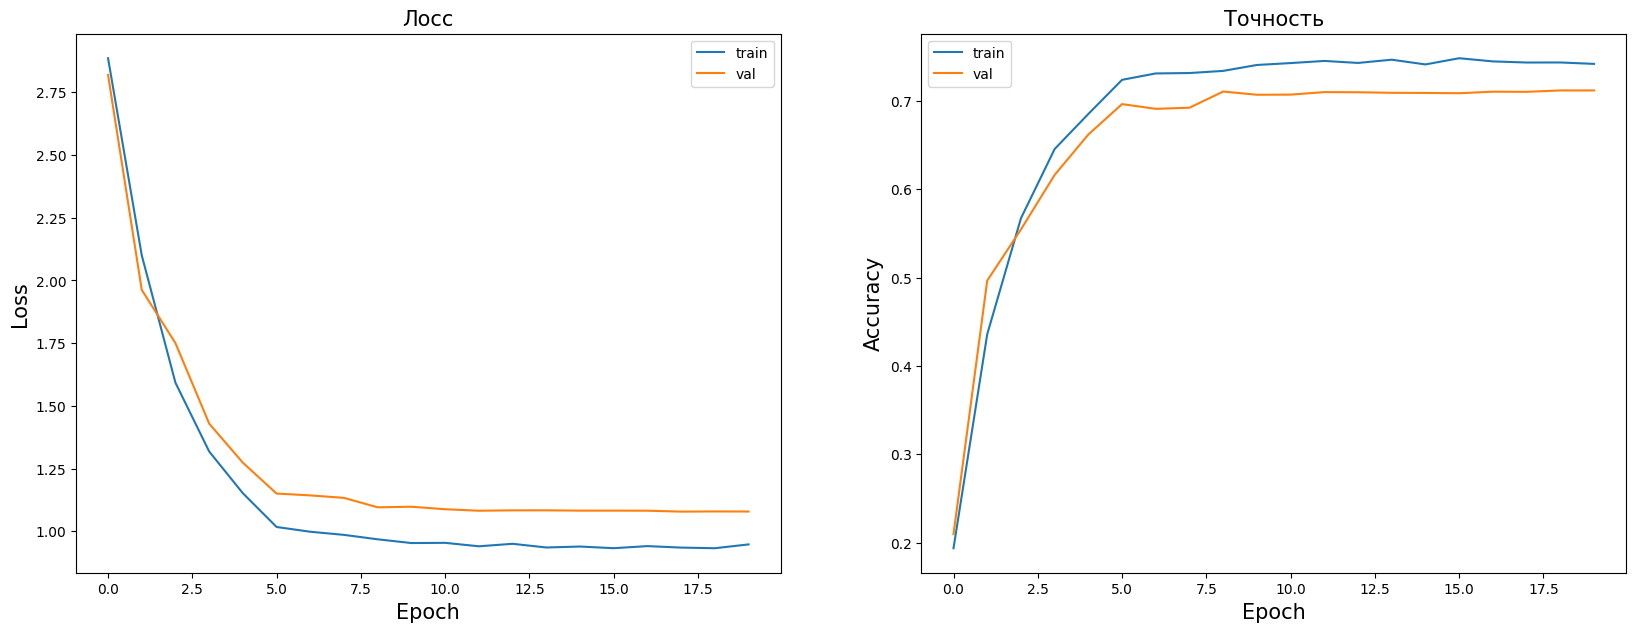

In [39]:
# дублирую настройки в блок с моделью для удобства
model_type = 'Fine_tuning'
augmentation_type = 'Very bad'
learning_rate = 0.01
# epochs = 20

fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('mobilenet_v3_small', mobilenet_v3_small(weights='DEFAULT'))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

# настраиваю scheduler
scheduler_type = 'StepLR'
schedulers = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
schedulers.append(scheduler)
s_names = 'StepLR'

clf_model, history = train(
    model_type,
    augmentation_type,
    learning_rate,    
    fine_tuning_model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=epochs,
    scheduler_type=scheduler_type,
    schedulers=schedulers,
    s_names=s_names
)

In [40]:
end_time = datetime.datetime.now()
print(f'start_time:\t{start_time}')
print(f'end_time:\t{end_time}')

start_time:	2024-03-05 07:17:46.318977
end_time:	2024-03-05 09:34:59.408538


In [41]:
df_results= pd.DataFrame(columns = [
  'model_type', 
  'augmentation_type', 
  'scheduler_type', 
  'epoch_list', 
  'learning_rat', 
  'test_accuracy', 
  'train_losses', 
  'test_accuracy', 
  'test_losses'])
for i in range(len(model_type_list)):
  df_results.loc[len(df_results.index)] = [
  model_type_list[i], 
  augmentation_type_list[i], 
  scheduler_type_list[i], 
  epoch_list[i], 
  l_rate[i], 
  train_accuracy[i], 
  train_losses[i], 
  test_accuracy[i], 
  test_losses[i]]
df_results.to_csv('Results.csv')
df_results

,model_type,augmentation_type,scheduler_type,epoch_list,learning_rat,test_accuracy,train_losses,test_accuracy,test_losses
0,From_zero,Optimal,None,1,0.010000,0.100993,3.650262,0.106376,3.659269
1,From_zero,Optimal,None,2,0.010000,0.110231,3.443086,0.106376,3.565636
2,From_zero,Optimal,None,3,0.010000,0.109661,3.186289,0.136206,3.292557
3,From_zero,Optimal,None,4,0.010000,0.172516,2.919460,0.162563,3.160451
4,From_zero,Optimal,None,5,0.010000,0.281600,2.603927,0.258365,3.013004
...,...,...,...,...,...,...,...,...,...
135,Fine_tuning,Very bad,StepLR,16,0.000010,0.748261,0.932781,0.708649,1.082508
136,Fine_tuning,Very bad,StepLR,17,0.000010,0.744672,0.941088,0.710385,1.082256
137,Fine_tuning,Very bad,StepLR,18,0.000010,0.743396,0.935203,0.710227,1.078559
138,Fine_tuning,Very bad,StepLR,19,0.000010,0.743461,0.932679,0.711806,1.079291


In [80]:
df_results[(df_results['model_type']=='Fine_tuning') 
        & ((df_results['augmentation_type']=='Optimal') | (df_results['augmentation_type']=='Very bad'))
        & (df_results['epoch_list']==20)
        & (df_results['scheduler_type']=='StepLR')
          ]

,model_type,augmentation_type,scheduler_type,epoch_list,learning_rat,train_accuracy,train_losses,test_accuracy,test_losses
99,Fine_tuning,Optimal,StepLR,20,0.000001,0.943904,0.227396,0.914141,0.326655
139,Fine_tuning,Very bad,StepLR,20,0.000001,0.741850,0.947857,0.711806,1.078962


##### Вот теперь цель достигнута - качество упало на 20%. Вывод - т.к. в большинстве случаев задача будет стоять улучшить качество, то применять аугментации следует с умом. Приведённые выше аугментации, на мой взгляд, могли бы быть полезны при обучении сети для обхода капчи, где как раз генерируются искажённые изображения.